---
# Classification of Biomedical Texts with Deep Learning: LSTM, GRU, and Self-Attention

---

**Few-shot training** is a learning paradigm in which a model is trained using only a very small number of labeled examples per class. In this study, Classification of Biomedical Texts with Deep Learning: LSTM, GRU, and Self-Attention, few-shot training is used to evaluate how well different deep learning architectures can generalize from limited annotated biomedical data.

This approach is especially relevant in biomedical domains where obtaining large labeled datasets is often expensive and time-consuming. By testing various models under few-shot conditions (e.g., 1, 5, or 20 examples per class), we aim to assess their robustness, adaptability, and efficiency in low-resource settings—providing insight into which architectures are better suited for real-world biomedical applications with limited training data.

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
import random
import time
import re

from tqdm import tqdm
import numpy as np
import torch
import wandb

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import ConcatDataset
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/diseases_dataset.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PMID                38652 non-null  int64 
 1   Title               38652 non-null  object
 2   Abstract            38652 non-null  object
 3   Keywords            38652 non-null  object
 4   PublicationYear     38652 non-null  int64 
 5   MeSH_Terms          38652 non-null  object
 6   Cleaned_Abstract    38652 non-null  object
 7   Disease             38652 non-null  object
 8   Top_Relevant_Words  38652 non-null  object
 9   Label               38652 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.9+ MB


In [ ]:
X = data["Cleaned_Abstract"].values
y = data["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 27056 samples
Validation set: 5798 samples
Test set: 5798 samples


In [ ]:
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

print(f"Combined Input Shape: {X_combined.shape}")
print(f"Combined Label Shape: {y_combined.shape}")

Combined Input Shape: (32854,)
Combined Label Shape: (32854,)


In [ ]:
def tokenize(text):
    """
    Tokenizes the input text by converting it to lowercase and splitting it into words.

    Args:
        text: A string containing the text to be tokenized.

    Returns:
        A list of tokens (words) from the text.
    """
    return re.findall(r'\b\w+\b', text.lower())

In [ ]:
all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}
VOCAB_SIZE =  40000

sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:VOCAB_SIZE])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}
print(word_to_index["malaria"])
print(index_to_word[1])

print(index_to_word[300])
print(word_to_index["host"])

1443
patient
relationship
351


In [ ]:
def text_to_sequence(text):
    """
    Converts the tokenized text into a sequence of indices based on a word-to-index mapping.

    Args:
        text: A string containing the text to be converted.

    Returns:
        A list of integers representing the sequence of token indices.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]

def pad_to_tensor(sequences, max_len=None):
    """
    Pads sequences to the specified maximum length, or truncates them if they exceed it.

    Args:
        sequences: A list of sequences (each sequence is a list of integers).
        max_len: The maximum length to which sequences should be padded. If None, no padding is applied.

    Returns:
        A tensor containing the padded (or truncated) sequences.
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]

    return torch.stack(padded_sequences)

class TextDataset(Dataset):
    """
    Custom Dataset for handling text data and labels.

    Args:
        X_data: Input features (e.g., tokenized text).
        y_data: Labels corresponding to the text data.
        raw_text_data: (Optional) The raw text data for reference (default is None).
    """
    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.raw_text_data = raw_text_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_tensor = self.X[idx]
        target_tensor = self.y[idx]

        raw_text = None
        if self.raw_text_data is not None and idx < len(self.raw_text_data):
            raw_text = self.raw_text_data[idx]

        return input_tensor, target_tensor, raw_text

def custom_collate_fn(batch):
    inputs, targets, raw_texts = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    return inputs, targets, list(raw_texts)

def load_glove_embeddings(glove_path, word_to_index, embedding_dim):
    """Loads GloVe embeddings and returns an embedding matrix."""
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = load_glove_embeddings('/content/drive/MyDrive/glove/glove.6B.300d.txt', word_to_index, EMBEDDING_DIM)

X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

print(X_train_seq[0])

[79, 347, 3, 40, 127, 119, 11, 445, 2521, 351, 89, 42, 342, 763, 7415, 333, 5299, 6666, 133, 448, 52, 18, 1464, 79, 4, 499, 295, 233, 31, 6666, 1243, 38, 18, 699, 389, 2717, 119, 11, 445, 161, 4, 2639, 611, 83, 1490, 387, 694, 112, 6666, 79, 412, 1440, 913, 557, 3331, 40001, 622, 728, 128, 4687, 909, 2871, 458, 64, 607, 4412, 219, 4, 190, 19, 7153, 8005, 190, 287, 375, 876, 74, 1354, 458, 93, 4, 229, 9, 654, 132, 6666, 233, 31, 1243, 917, 2298, 213, 38, 4283, 18, 775, 43, 114, 136, 445, 9, 337, 6666, 40, 429, 80, 11, 301, 79]


In [ ]:
max_length = 400

X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}, Type: {X_train_tensor.dtype}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}, Type: {X_val_tensor.dtype}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, Type: {X_test_tensor.dtype}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

Train Tensor Shape: torch.Size([27056, 400]), Type: torch.int64
Validation Tensor Shape: torch.Size([5798, 400]), Type: torch.int64
Test Tensor Shape: torch.Size([5798, 400]), Type: torch.int64


In [ ]:
X_combined_tensor = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_combined_tensor = torch.cat((y_train_tensor, y_val_tensor), dim=0)

print(f"Combined Input Tensor Shape: {X_combined_tensor.shape}")
print(f"Combined Label Tensor Shape: {y_combined_tensor.shape}")

Combined Input Tensor Shape: torch.Size([32854, 400])
Combined Label Tensor Shape: torch.Size([32854])


In [ ]:
train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


In [ ]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)


print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Training set size: 27056
Validation set size: 5798
Test set size: 5798
Combined dataset size: 32854


In [ ]:
NUM_CLASSES = len(torch.unique(y_train_tensor))
VOCAB_SIZE = len(word_to_index)

# ============ Define Hybrid CNN-LSTM Model ============
class CNN_LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES, num_layers=1, dropout_prob=0.3, num_filters=100, kernel_size=3):
        super(CNN_LSTM_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conv_out = self.relu(self.conv1(embedded))
        conv_out = self.relu(self.conv2(conv_out))
        conv_out = self.pool(conv_out)

        conv_out = conv_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(conv_out)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

# ==========================  GRU Model with Word Embeddings ==========================
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES , num_layers=1, dropout_prob=0.5, embedding_weights=None, freeze_embeddings=False):
        super(GRU_Model, self).__init__()

        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0  # Dropout only if num_layers > 1
        )

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = self.dropout(gru_out[:, -1, :])
        out = self.fc(gru_out)
        return out

# ========================== Bahdanau Attention ==========================
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention Mechanism.

    This class implements the Bahdanau attention mechanism as described in the paper:
    "Neural Machine Translation by Jointly Learning to Align and Translate" by Bahdanau et al.

    Args:
        hidden_dim (int): The hidden dimension of the GRU or LSTM output.

    Attributes:
        W (nn.Linear): A linear layer for the transformation of the RNN outputs.
        v (nn.Linear): A linear layer for computing attention scores.
    """
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, rnn_outputs):
        """
        Apply the attention mechanism on the RNN outputs.

        Args:
            rnn_outputs (Tensor): The outputs of the RNN (GRU or LSTM).

        Returns:
            Tensor: The context vector computed by the attention mechanism.
        """
        score = torch.tanh(self.W(rnn_outputs))
        attn_weights = torch.softmax(self.v(score), dim=1)
        context = torch.sum(attn_weights * rnn_outputs, dim=1)
        return context

# ========================== Bidirectional GRU + Bahdanau Ateention  ==========================
class GloVe_GRU_BahdanauAttention(nn.Module):
    """
    Model using GloVe embeddings, GRU layers, and Bahdanau Attention for classification.

    Args:
        embedding_matrix (Tensor): Pretrained GloVe embedding matrix.
        hidden_dim (int): Hidden size for the GRU.
        num_classes (int): Output classes.
        num_layers (int): GRU depth.
        dropout_prob (float): Dropout rate.
    """
    def __init__(self, embedding_matrix, hidden_dim, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.6):
        super(GloVe_GRU_BahdanauAttention, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Args:
            x (Tensor): Tensor of token indices (batch_size, seq_len)

        Returns:
            Tensor: Output logits for classification.
        """
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output

In [ ]:
clip = 5.0

def epoch_time(start_time, end_time):
    """
    Calculates the elapsed time between the start and end time.

    Args:
        start_time: The start time (in seconds).
        end_time: The end time (in seconds).

    Returns:
        elapsed_mins: The elapsed time in minutes.
        elapsed_secs: The elapsed time in seconds.
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y_true):
    """
    Computes accuracy for multi-class classification.
    Args:
        y_pred: Raw logits from the model (before softmax).
        y_true: True class labels (integer class indices).
    Returns:
        Accuracy score.
    """
    y_pred = torch.argmax(y_pred, dim=1)  # Get predicted class index
    correct = (y_pred == y_true).sum().item()
    total = y_true.size(0)  # Number of samples
    return correct / total

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_accuracy = 0, 0

    for batch in train_loader:
        if len(batch) == 3:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        optimizer.zero_grad()
        output = model(input_tensor)  # Forward pass
        loss = criterion(output, target_tensor)  # Compute loss
        loss.backward()  # Backpropagation

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, target_tensor)

        total_loss += loss.item()
        total_accuracy += batch_accuracy * len(target_tensor)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader.dataset)

    return avg_loss, avg_accuracy

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch.
    Args:
        model: Model instance.
        val_loader: DataLoader for validation data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average validation loss, accuracy, and F1-score.
    """
    model.eval()  # Set to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass

            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader.dataset)

    return avg_loss, avg_accuracy, f1

def get_hidden_states(model, dataloader, device):
    """
    This function extracts the hidden states from a model (either GRU or LSTM) for each sample in the dataloader.
    The hidden states are taken from the last time step of the sequence, which are typically used for classification tasks.

    Args:
        model: A PyTorch model that contains an embedding layer and either a GRU or LSTM layer.
        dataloader: A DataLoader containing batches of input data and their corresponding targets.
        device: The device (CPU or GPU) to run the model on.

    Returns:
        hidden_states: A numpy array containing the hidden states for each sample in the dataloader.
        labels: A numpy array containing the target labels corresponding to each input sample.
    """
    model.eval()
    hidden_states, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets, _ = batch
            inputs = inputs.to(device)

            embedded = model.embedding(inputs)

            if hasattr(model, "gru"):
                gru_out, _ = model.gru(embedded)
                hidden_state = gru_out[:, -1, :]

            elif hasattr(model, "lstm"):
                lstm_out, (hidden, _) = model.lstm(embedded)
                hidden_state = hidden[-1]

            else:
                raise ValueError("Unsupported model type. Model must contain GRU or LSTM.")

            hidden_states.append(hidden_state.cpu().numpy())
            labels.append(targets.cpu().numpy())

    hidden_states = np.concatenate(hidden_states, axis=0)
    labels = np.concatenate(labels, axis=0)

    return hidden_states, labels

def count_parameters(model):
    """
    Computes the total number of trainable parameters in a model.

    Args:
        model: A PyTorch model instance.

    Returns:
        The total number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def reinitialize_weights(model):
    """Reinitializes the model's weights by calling reset_parameters() for each layer that supports it."""
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def test_epoch(model, test_loader, criterion, device):
    """
    Validate the model for one epoch, including precision, F1, balanced accuracy, and recall.
    Args:
        model: Model instance.
        test_loader: DataLoader for test data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, Recall, and Precision.
    """
    model.eval()  # Set model to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass
            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

In [ ]:
loss_gap_ratio = 1.25
ax_accuracy_gap = 5

def get_few_shot_subset(X_tensor, y_tensor, k_shot):
    X_few = []
    y_few = []
    unique_classes = torch.unique(y_tensor)
    for cls in unique_classes:
        indices = (y_tensor == cls).nonzero(as_tuple=True)[0]
        selected = indices[torch.randperm(len(indices))[:k_shot]]
        X_few.append(X_tensor[selected])
        y_few.append(y_tensor[selected])
    X_few = torch.cat(X_few)
    y_few = torch.cat(y_few)
    return X_few, y_few

def train_and_evaluate_model(model, k, X_combined_tensor, y_combined_tensor, optimizer, loss_function, num_epochs, batch_size, test_loader, model_name, embedding_matrix=None):
    reinitialize_weights(model)
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    test_f1s, test_balanced_accs, test_recalls, test_precisions = [], [], [], []
    saved_once = False
    X_few, y_few = get_few_shot_subset(X_combined_tensor, y_combined_tensor, k_shot=k)
    few_shot_dataset = TextDataset(X_few, y_few, raw_text_data=X_combined)
    few_shot_loader = DataLoader(few_shot_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    wandb.init(project=f'Few-Shot-Training-{model_name}-', name=f"{model_name}_K-{k}_Training", config={'learning_rate': 7e-4, 'num_epochs': num_epochs, 'num_layers': 1, 'k_shot': k})
    with tqdm(total=num_epochs, desc=f"Training {model_name} with {k}-shot", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()
            train_loss, train_acc = train_epoch(model, few_shot_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_epoch(model, test_loader, loss_function, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            test_f1s.append(test_f1)
            test_balanced_accs.append(test_balanced_acc)
            test_recalls.append(test_recall)
            test_precisions.append(test_precision)
            wandb.log({
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "test_f1": test_f1,
                "test_balanced_acc": test_balanced_acc,
                "test_recall": test_recall,
                "test_precision": test_precision,
                "epoch": epoch + 1,
                "k_shot": k
            })

            if (test_loss > train_loss * loss_gap_ratio or (train_acc > test_acc and train_acc - test_acc > ax_accuracy_gap / 100)) and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_K-{k}_multi_class_loss_gap_accuracy_gap_10%.pth")
                saved_once = True
                print(f"Early stopping triggered at epoch {epoch+1}")
                print(f"Model {model_name}_K-{k} saved with loss gap > 1.25 or accuracy gap > 10% at epoch {epoch}.")
                break
            if epoch == num_epochs - 1 and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_K-{k}_multi_class_final.pth")
                print(f"Model {model_name}_K-{k} saved at the end of epoch {num_epochs}.")
                print(f"Model metrics: \nTest Accuracy: {test_acc:.2%}, Test F1: {test_f1:.2%}, Test Balanced Accuracy: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}")
            pbar.set_description(f"{model_name} K-{k} Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.2%}, Test Acc: {test_acc:.2%}, Test F1: {test_f1:.2%}, Test Balanced Acc: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}, Time: {time.time() - start_time:.2f} sec")
            pbar.update(1)
    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "test_f1s": test_f1s,
        "test_balanced_accs": test_balanced_accs,
        "test_recalls": test_recalls,
        "test_precisions": test_precisions
    }

def plot_max_metrics(model_metrics, k_values):
    fig, axes = plt.subplots(1, 4, figsize=(16, 6))
    sns.set(style="whitegrid")

    for i, (model_name, metrics) in enumerate(model_metrics.items()):
        f1_values = []
        balanced_acc_values = []
        recall_values = []
        precision_values = []

        for k in k_values:
            f1_values.append(metrics['test_f1s'][k_values.index(k)])
            balanced_acc_values.append(metrics['test_balanced_accs'][k_values.index(k)])
            recall_values.append(metrics['test_recalls'][k_values.index(k)])
            precision_values.append(metrics['test_precisions'][k_values.index(k)])

        axes[0].plot(k_values, f1_values, label=model_name, marker='o')
        axes[1].plot(k_values, balanced_acc_values, label=model_name, marker='o')
        axes[2].plot(k_values, recall_values, label=model_name, marker='o')
        axes[3].plot(k_values, precision_values, label=model_name, marker='o')

    axes[0].set_title("F1 Score", fontsize=16)
    axes[0].set_xlabel("K-shot", fontsize=14)
    axes[0].set_ylabel("F-1 Score", fontsize=14)
    axes[0].legend(title=None, loc="upper right", framealpha=0.005)
    axes[0].grid(True)

    axes[1].set_title("Balanced Accuracy", fontsize=16)
    axes[1].set_xlabel("K-shot", fontsize=14)
    axes[1].set_ylabel("Balanced Accuracy", fontsize=14)
    axes[1].legend(title=None, loc="upper right", framealpha=0.005)
    axes[1].grid(True)

    axes[2].set_title("Recall", fontsize=16)
    axes[2].set_xlabel("K-shot", fontsize=14)
    axes[2].set_ylabel("Recall", fontsize=14)
    axes[2].legend(title=None, loc="upper right", framealpha=0.005)
    axes[2].grid(True)

    axes[3].set_title("Precision", fontsize=16)
    axes[3].set_xlabel("K-shot", fontsize=14)
    axes[3].set_ylabel("Precision", fontsize=14)
    axes[3].legend(title=None, loc="upper right", framealpha=0.005)
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()

---
# Few-Shot Training
---

In [ ]:
models_info = {
    "CNN_LSTM": CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=150, hidden_dim=100, num_layers=1, dropout_prob=0.3).to(device),
    "Glove-GRU": GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=100, num_layers=1, dropout_prob=0.4).to(device),
    "Glove-GRU-Bahdanau": GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=100, num_layers=1, dropout_prob=0.9).to(device)
}

optimizers = {
    "CNN_LSTM": torch.optim.AdamW(models_info["CNN_LSTM"].parameters(), lr=7e-4),
    "Glove-GRU": torch.optim.Adam(models_info["Glove-GRU"].parameters(), lr=7e-4),
    "Glove-GRU-Bahdanau": torch.optim.Adam(models_info["Glove-GRU-Bahdanau"].parameters(), lr=1e-4)
}

model_metrics = {}

k_values = [5, 10, 20, 30, 50, 60, 70, 80, 100, 150, 200, 400, 600]
for k in k_values:
    print(f"\nTraining with {k}-shot...")
    for model_name, model in models_info.items():
        optimizer = optimizers[model_name]
        if model_name not in model_metrics:
            model_metrics[model_name] = {
                "test_f1s": [],
                "test_balanced_accs": [],
                "test_recalls": [],
                "test_precisions": []
            }

        results = train_and_evaluate_model(
            model, k, X_combined_tensor, y_combined_tensor, optimizer, torch.nn.CrossEntropyLoss(), num_epochs=1000, batch_size=batch_size,
            test_loader=test_loader, model_name=model_name, embedding_matrix=embedding_matrix
        )

        model_metrics[model_name]['test_f1s'].append(max(results['test_f1s']))
        model_metrics[model_name]['test_balanced_accs'].append(max(results['test_balanced_accs']))
        model_metrics[model_name]['test_recalls'].append(max(results['test_recalls']))
        model_metrics[model_name]['test_precisions'].append(max(results['test_precisions']))


Training with 5-shot...


<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM K-5 Epoch 1/1000 - Train Loss: 2.2049, Test Loss: 2.2020, Train Acc: 4.44%, Test Acc: 10.52%, Test F1: 2.09%, Test Balanced Acc: 11.20%, Test Recall: 10.52%, Test Precision: 2.12%, Time: 2.49 sec:   0%|          | 1/1000 [00:03<52:55,  3.18s/epoch]

Early stopping triggered at epoch 2
Model CNN_LSTM_K-5 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 1.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁█
k_shot,▁▁
test_acc,█▁
test_balanced_acc,█▁
test_f1,█▁
test_loss,█▁
test_precision,█▁
test_recall,█▁
train_acc,▁█
train_loss,█▁
epoch,2


Glove-GRU K-5 Epoch 7/1000 - Train Loss: 2.2314, Test Loss: 2.1999, Train Acc: 13.33%, Test Acc: 12.18%, Test F1: 2.74%, Test Balanced Acc: 11.12%, Test Recall: 12.18%, Test Precision: 8.78%, Time: 1.19 sec:   1%|          | 7/1000 [00:06<14:28,  1.14epoch/s]

Early stopping triggered at epoch 8
Model Glove-GRU_K-5 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 7.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▄▅▆▇█
k_shot,▁▁▁▁▁▁▁▁
test_acc,▁▁▁▆▄███
test_balanced_acc,▆▆█▃▇▁▁▂
test_f1,▁▁▁▆▅███
test_loss,█▄▂▁▂▁▁▄
test_precision,▄▆█▆▇▁▁▆
test_recall,▁▁▁▆▄███
train_acc,▁▃▄▂▃▂▆█
train_loss,█▃▁▄▄▄▁▂
epoch,8


Glove-GRU-Bahdanau K-5 Epoch 7/1000 - Train Loss: 2.3179, Test Loss: 2.2047, Train Acc: 8.89%, Test Acc: 11.07%, Test F1: 4.34%, Test Balanced Acc: 10.74%, Test Recall: 11.07%, Test Precision: 7.22%, Time: 0.94 sec:   1%|          | 7/1000 [00:08<20:05,  1.21s/epoch]

Early stopping triggered at epoch 8
Model Glove-GRU-Bahdanau_K-5 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 7.

Training with 10-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▄▅▆▇█
k_shot,▁▁▁▁▁▁▁▁
test_acc,█▆▅▄▄▃▄▁
test_balanced_acc,█▆▆▅▄▃▄▁
test_f1,▁▁▁▂▃▅▇█
test_loss,█▆▅▃▂▂▁▁
test_precision,█▅▂▁▅▄█▇
test_recall,█▆▅▄▄▃▄▁
train_acc,▂▅▄▄▄▁▄█
train_loss,█▂▆▅▆▇▅▁
epoch,8


CNN_LSTM K-10 Epoch 9/1000 - Train Loss: 2.1745, Test Loss: 2.1979, Train Acc: 14.44%, Test Acc: 12.26%, Test F1: 2.76%, Test Balanced Acc: 11.08%, Test Recall: 12.26%, Test Precision: 7.23%, Time: 0.66 sec:   1%|          | 9/1000 [00:06<12:40,  1.30epoch/s]

Early stopping triggered at epoch 10
Model CNN_LSTM_K-10 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 9.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▃▄▅▆▆▇█
k_shot,▁▁▁▁▁▁▁▁▁▁
test_acc,▇█▇▆▅▁▅▅▆▆
test_balanced_acc,▆█▄▃▁▃▁▁▃▃
test_f1,▃▅██▅▁▅▅██
test_loss,▂▁▅▃▅▇▇█▇▄
test_precision,▁█▅▅▂▂▂▂█▅
test_recall,▇█▇▆▅▁▅▅▆▆
train_acc,▃▃▄▂▅▂▁▃▅█
train_loss,█▇▆▆▅▄▅▅▃▁
epoch,10


Glove-GRU K-10 Epoch 13/1000 - Train Loss: 2.2375, Test Loss: 2.2083, Train Acc: 10.00%, Test Acc: 9.33%, Test F1: 3.13%, Test Balanced Acc: 10.75%, Test Recall: 9.33%, Test Precision: 14.08%, Time: 0.59 sec:   1%|▏         | 13/1000 [00:08<11:22,  1.45epoch/s]

Early stopping triggered at epoch 14
Model Glove-GRU_K-10 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 13.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▇█▇███▇▇▁█▇▆▄▇
test_balanced_acc,▆▅▅▅▆▅▆▆▅█▇▅▁▅
test_f1,▅▅▅▅▅▅▄▄▁▆▆█▆▇
test_loss,▅▂▄▃▁▇▃▄█▇▄▃▅▄
test_precision,█▁▇▇▃▇▇▇▇█▃█▆▇
test_recall,▇█▇███▇▇▁█▇▆▄▇
train_acc,▁▃▂▄▇▇▄▃▃▇▄▃▄█
train_loss,█▆▅▆▁▃▆▇▅▄▄▅▄▃
epoch,14


Glove-GRU-Bahdanau K-10 Epoch 1/1000 - Train Loss: 2.4951, Test Loss: 2.2013, Train Acc: 8.89%, Test Acc: 11.26%, Test F1: 3.41%, Test Balanced Acc: 10.21%, Test Recall: 11.26%, Test Precision: 4.62%, Time: 1.02 sec:   0%|          | 1/1000 [00:02<35:45,  2.15s/epoch]

Early stopping triggered at epoch 2
Model Glove-GRU-Bahdanau_K-10 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 1.

Training with 20-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁█
k_shot,▁▁
test_acc,█▁
test_balanced_acc,█▁
test_f1,▁█
test_loss,▁█
test_precision,█▁
test_recall,█▁
train_acc,▁█
train_loss,█▁
epoch,2


CNN_LSTM K-20 Epoch 201/1000 - Train Loss: 2.1862, Test Loss: 2.1978, Train Acc: 11.67%, Test Acc: 10.54%, Test F1: 2.12%, Test Balanced Acc: 11.22%, Test Recall: 10.54%, Test Precision: 2.23%, Time: 0.72 sec:  20%|██        | 201/1000 [02:32<10:06,  1.32epoch/s]

Early stopping triggered at epoch 202
Model CNN_LSTM_K-20 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 201.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,████▁▅▄█▄██▄▄▅▅▅▄▆▆▆▄▄▅█▇▇▅▅▅▅▆▆▆▇▁▁▁▁▁▁
test_balanced_acc,▄▇▇▇▇▅▅▆▄▄▅▄▄▄▄▄▆▄▅▅▅▆▂▅▂▅▅▅▅▅▅▅▅▁▁▁█▇▇▇
test_f1,▇███▆▅▅█▄▄████▅▅▅▅▅▅▅██▅▅▅▆▆▆▆▁▁▁▁▁▅▁▅▁▁
test_loss,▃▁▁▃▂▂▄▄▃▃▂▂▂▂▂▁▂▁▃▃██▅▅▅▄▄▃▃▅▅▄▄▃▃▃▄▄▅▅
test_precision,▆▃▁▁█▂▃▃▂▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▃▃▃▃▇▁▁▁
test_recall,█▁▁▅█▄████▇▄▄▅▅▄▆▄▇█▆▆▇██▅▆▅▅▆▁▁▁▁▅▅▁▁▁▁
train_acc,▄▆▃▆▅▄▇▆▆▄▂▂▃▆▃▆▁▅▅▅▆█▄▄▄▅▆▆▅▅▃▇▅▄▅▄▆▁▃▅
train_loss,███▇▇█▇▇▇█▇▇▇█▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▁█▇▇▁▇
epoch,202


Glove-GRU K-20 Epoch 26/1000 - Train Loss: 2.1270, Test Loss: 2.1934, Train Acc: 18.33%, Test Acc: 13.38%, Test F1: 8.74%, Test Balanced Acc: 12.87%, Test Recall: 13.38%, Test Precision: 12.97%, Time: 0.64 sec:   3%|▎         | 26/1000 [00:18<11:29,  1.41epoch/s]

Early stopping triggered at epoch 27
Model Glove-GRU_K-20 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 26.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▆▆▄▆▅▅▆▆▅▆▆▅▄▅▁▆▆▅▄▆▆▇▇▇▇▇█
test_balanced_acc,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▃▂▄▄▃▆▆▅▅▆█
test_f1,▂▂▁▂▁▁▂▂▁▂▂▁▁▂▂▃▃▃▅▅▄▇▆▅▅█▇
test_loss,█▄▅▃▅▆▅▄▄▃▄▄▃▂▆▄▂▃▄▂▂▄▁▂▄▂▁
test_precision,▆▆▆▇▇▇▆▆▁▃▆▅▃▄▆▇▁▇▃▂▆█▃▄▇▅▅
test_recall,▆▆▄▆▅▅▆▆▅▆▆▅▄▅▁▆▆▅▄▆▆▇▇▇▇▇█
train_acc,▃▂▂▂▃▄▄▃▃▂▄▂▃▃▂▁▂▂▃▅▄▄▄▅▆▆█
train_loss,▇███▇▅▇▇▆▇▅▇▄▅▅▇▆▅▅▄▄▃▃▄▁▂▁
epoch,27


Glove-GRU-Bahdanau K-20 Epoch 53/1000 - Train Loss: 1.3124, Test Loss: 1.2978, Train Acc: 70.00%, Test Acc: 71.49%, Test F1: 67.71%, Test Balanced Acc: 72.75%, Test Recall: 71.49%, Test Precision: 72.74%, Time: 1.09 sec:   5%|▌         | 53/1000 [01:00<17:55,  1.14s/epoch]

Early stopping triggered at epoch 54
Model Glove-GRU-Bahdanau_K-20 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 53.

Training with 30-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇█████
test_balanced_acc,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇█████
test_f1,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇█████
test_loss,█████████████████▇▇▇▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁
test_precision,▁▁▁▂▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██████
test_recall,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇█████
train_acc,▁▂▂▁▁▂▁▂▂▂▂▂▂▃▃▂▃▃▃▃▄▄▄▄▄▃▅▄▅▅▅▅▅▆▆▇▇▇▆█
train_loss,█▇▇▇▇▇▆▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▂▁
epoch,54


CNN_LSTM K-30 Epoch 57/1000 - Train Loss: 2.1594, Test Loss: 2.2040, Train Acc: 12.59%, Test Acc: 11.35%, Test F1: 2.46%, Test Balanced Acc: 11.04%, Test Recall: 11.35%, Test Precision: 2.84%, Time: 0.77 sec:   6%|▌         | 57/1000 [00:45<12:37,  1.25epoch/s]

Early stopping triggered at epoch 58
Model CNN_LSTM_K-30 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 57.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,█▂▂▂▂▂▂▇▇▇▂▂▂▂▂▂▂▂▂▂█▂▂▁▁▁▂▂▁▂▁▇▇▁▁▁▁▁▂▂
test_balanced_acc,▂▄▄▆▇▇▇▇▇▅▇█▇▇▇▇▇▇▆▆▃▅▃▃▁▂▇██▂▃▂▂▂▁▂▁▂▄▃
test_f1,▁▁▃▃▂▂▂▃▆▇▃▂▂▂▂▂▃▃▄▄▃▃▃█▃▃█▄▃▆▆▆▃▆▂▆▃▂▂▂
test_loss,▂▂▂▂▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▄▄▄▅▅█▅▄▄▄▄▄▄▅▅▅▅▅▅
test_precision,▁▁▁▂▃▂▃▂▃▂█▄▂▂▂▂▃▄▅▆▃▂▂▂▂▂▂▂▄▃▂▂▃▂▂▂▂▃▂▂
test_recall,▇▁▂▂▂▂▂▂▂▂▇▇▇▂▂▂▂▂▂▂▂▁█▁▁▇▁▁▇▁▁▇▁▁▇▁▁▁▁▁
train_acc,▁▄▅▄▁▄▆▅▃▅▅▅▅▅▆▅▂▂▄▃▄▆▅▆▄▇▃▄▄▄▄▂▅▃▃▅▅▄▃█
train_loss,█▇▆▅▄▃▃▃▃▃▂▃▃▃▃▃▃▂▃▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,58


Glove-GRU K-30 Epoch 8/1000 - Train Loss: 2.2288, Test Loss: 2.2014, Train Acc: 14.81%, Test Acc: 12.12%, Test F1: 2.95%, Test Balanced Acc: 11.08%, Test Recall: 12.12%, Test Precision: 13.44%, Time: 0.80 sec:   1%|          | 8/1000 [00:06<13:51,  1.19epoch/s]

Early stopping triggered at epoch 9
Model Glove-GRU_K-30 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 8.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▄▅▅▆▇█
k_shot,▁▁▁▁▁▁▁▁▁
test_acc,▆█▂▅█▁▂▇▆
test_balanced_acc,▁▁▁▁▁▅█▁▂
test_f1,▂▃▁▂▃▄█▃▆
test_loss,▁██▃▆▆▇▄▃
test_precision,▆███▃▄▆▁▄
test_recall,▆█▂▅█▁▂▇▆
train_acc,▅▄▁▁▃▄▄▆█
train_loss,▄██▆▇▅▄▄▁
epoch,9


Glove-GRU-Bahdanau K-30 Epoch 31/1000 - Train Loss: 1.3328, Test Loss: 1.3946, Train Acc: 60.37%, Test Acc: 60.75%, Test F1: 59.01%, Test Balanced Acc: 61.49%, Test Recall: 60.75%, Test Precision: 61.26%, Time: 1.14 sec:   3%|▎         | 31/1000 [00:37<19:28,  1.21s/epoch]

Early stopping triggered at epoch 32
Model Glove-GRU-Bahdanau_K-30 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 31.

Training with 50-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██████
test_balanced_acc,▁▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██████
test_f1,▁▁▂▂▂▂▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
test_loss,████████▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁
test_precision,▁▁▁▂▂▂▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████
test_recall,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██████
train_acc,▁▁▁▂▂▂▂▂▂▃▃▃▄▃▄▅▄▅▄▅▅▅▆▆▆▇▇▇▇▇▇█
train_loss,█▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▁▁▁▁
epoch,32


CNN_LSTM K-50 Epoch 69/1000 - Train Loss: 2.1694, Test Loss: 2.2139, Train Acc: 8.67%, Test Acc: 6.71%, Test F1: 0.92%, Test Balanced Acc: 10.97%, Test Recall: 6.71%, Test Precision: 3.17%, Time: 0.84 sec:   7%|▋         | 69/1000 [01:01<13:49,  1.12epoch/s]

Early stopping triggered at epoch 70
Model CNN_LSTM_K-50 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 69.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,█▇▇▇▁█▇▇▇█▇▇▇█▇▇▇▇▇▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁
test_balanced_acc,▆█▆▆▅▆▅▅▅▅▃▆▅▅▅▅▅▅▂▄▄▃▃▂▄▁▁▃▃▂▃▃▅▅▁▃▃▃▃▂
test_f1,▇▇▇▇▁▇▇▇▇▇▇▇▇▇▇▇██▇▇▆▇▆▆▆▇▇▆▆▇▇▇▇▇▆▇▇▇█▁
test_loss,▃▁▂▂▂▁▁▂▂▂▃▂▂▃▃▅▆▆▆▃▆▄▅▅▅▅▆▆▇▆▆▆▆▆▆▆▆▆▇█
test_precision,▅▄▃▃▃▃▃▃▃▁▄▃▃▃▃▃▃▃▃▃▃▅█▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▂
test_recall,▇▇▇▁█▇▇▆▆▇█▇▇▇▇██▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁
train_acc,▅▇▅▄▆▅▄▃▂█▄▅█▇▆▂▅▅▁▄▆▅▃▅▄▅▇▅▅▆▃▁▄▇▆▅▆▅▅▇
train_loss,██▇▇▆▆▆▂▅▆▆▅▆▅▅▅▅▅▅▆▅▆▅▅▅▅▅▅▅▅▅▅▁▅▅▅▅▅▅▅
epoch,70


Glove-GRU K-50 Epoch 11/1000 - Train Loss: 2.1026, Test Loss: 2.1847, Train Acc: 17.78%, Test Acc: 14.19%, Test F1: 8.03%, Test Balanced Acc: 15.74%, Test Recall: 14.19%, Test Precision: 26.33%, Time: 0.78 sec:   1%|          | 11/1000 [00:09<14:55,  1.10epoch/s]

Early stopping triggered at epoch 12
Model Glove-GRU_K-50 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 11.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▂▃▄▄▅▅▆▇▇█
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▄▄▅▃▅▄▄▅█▅█▁
test_balanced_acc,▁▁▂▁▂▂▁▃▄▅█▅
test_f1,▁▁▃▁▄▄▃▅▆▅█▂
test_loss,█▄▅▄▃▃▃▃▂▂▁▃
test_precision,█▅▆▇▄▃▃▇▄▁▄▄
test_recall,▄▄▅▃▅▄▄▅█▅█▁
train_acc,▂▁▃▂▄▄▄▄▄▆▆█
train_loss,▇█▆▇▆▆▅▅▄▃▃▁
epoch,12


Glove-GRU-Bahdanau K-50 Epoch 24/1000 - Train Loss: 1.3848, Test Loss: 1.4383, Train Acc: 56.89%, Test Acc: 55.07%, Test F1: 54.21%, Test Balanced Acc: 54.44%, Test Recall: 55.07%, Test Precision: 54.35%, Time: 1.27 sec:   2%|▏         | 24/1000 [00:32<22:07,  1.36s/epoch]

Early stopping triggered at epoch 25
Model Glove-GRU-Bahdanau_K-50 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 24.

Training with 60-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▁▁▂▂▃▄▄▅▅▅▅▆▆▆▇▇▇▇██████
test_balanced_acc,▁▁▁▂▂▃▄▄▅▅▅▅▆▆▆▇▇▇▇██████
test_f1,▁▁▂▂▂▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇█████
test_loss,██████▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁
test_precision,▁▁▂▂▃▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█████
test_recall,▁▁▁▂▂▃▄▄▅▅▅▅▆▆▆▇▇▇▇██████
train_acc,▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▆▇█▇█
train_loss,████▇▇▇▇▆▆▅▅▅▅▅▄▄▃▃▂▂▂▂▂▁
epoch,25


CNN_LSTM K-60 Epoch 197/1000 - Train Loss: 2.1896, Test Loss: 2.2099, Train Acc: 11.11%, Test Acc: 11.59%, Test F1: 2.60%, Test Balanced Acc: 11.12%, Test Recall: 11.59%, Test Precision: 6.05%, Time: 0.89 sec:  20%|█▉        | 197/1000 [03:01<12:18,  1.09epoch/s]

Early stopping triggered at epoch 198
Model CNN_LSTM_K-60 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 197.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▇▇▇▆█▆▇▆▆▇▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▆█▇▆▇▇▇▇▇▁
test_balanced_acc,▅▄▅▅▁▇▅▄▆▄▅▅▆▆▅▅▅▅▅▃▅▅▅▅▅▄▄▃▂▄▇▃▃▅▄█▆▅▅▅
test_f1,▇▇▆▆▇▇▇▇▇▅▅▇▇▇▇▅▇▁▇▇▆▅▆▇▆▆▇▇▇▆██▇▇▇▇▇▇▇▇
test_loss,▁▁▁▂▂▄▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▃▃▃▇▇████████
test_precision,▂▁▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▃▄▄▄▄█
test_recall,▇▇▇▇▇█▇▆▆▆▇▇██▇▆▇█▇▇█▇█▇█▇▇▁▇▇█▇▇▇▇█▇▇▇▇
train_acc,▅▄▄▆▃▆█▅▂▃▅▆▆▁▅█▄█▇▆▄▆▅▇▃▅▄▄▃▃▆▃▂▄▃▂▂▃▆▆
train_loss,█▇▆▃▃▂▂▂▂▃▂▂▃▂▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▂▂
epoch,198


Glove-GRU K-60 Epoch 19/1000 - Train Loss: 2.0124, Test Loss: 2.1819, Train Acc: 18.52%, Test Acc: 14.07%, Test F1: 6.56%, Test Balanced Acc: 14.35%, Test Recall: 14.07%, Test Precision: 22.45%, Time: 0.81 sec:   2%|▏         | 19/1000 [00:17<14:40,  1.11epoch/s]

Early stopping triggered at epoch 20
Model Glove-GRU_K-60 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 19.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▄▅▅▁▅▅▅▄▅▅▆▅▅▆▆▅▆█▇▇
test_balanced_acc,▂▂▁▂▂▂▂▁▂▁▃▂▂▃█▂▄▇▆▄
test_f1,▂▃▃▁▃▃▃▄▃▃▅▃▃▆▅▄▆█▇▆
test_loss,▄▃▂▃▃▂▃▂▃▂▃▃▂▃▂▂▁▁▁█
test_precision,▃▃▁▃▄▃▄▄▂▃█▅█▅▇▂▅▅▄▃
test_recall,▄▅▅▁▅▅▅▄▅▅▆▅▅▆▆▅▆█▇▇
train_acc,▁▂▂▂▃▃▃▂▂▁▂▂▃▃▄▄▅▆▅█
train_loss,███▇▇▇▇▇▇▇▇▇▇▆▆▆▅▅▄▁
epoch,20


Glove-GRU-Bahdanau K-60 Epoch 24/1000 - Train Loss: 1.4677, Test Loss: 1.5919, Train Acc: 51.11%, Test Acc: 47.72%, Test F1: 46.00%, Test Balanced Acc: 49.77%, Test Recall: 47.72%, Test Precision: 46.17%, Time: 1.32 sec:   2%|▏         | 24/1000 [00:34<23:06,  1.42s/epoch]

Early stopping triggered at epoch 25
Model Glove-GRU-Bahdanau_K-60 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 24.

Training with 70-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▂▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████
test_balanced_acc,▁▂▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇██████
test_f1,▁▂▂▃▄▄▄▄▅▅▆▆▆▇▇▇▇▇▇██████
test_loss,███▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
test_precision,▁▂▂▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇██████
test_recall,▁▂▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████
train_acc,▁▁▂▂▂▃▄▄▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇██
train_loss,███▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▁▁▁
epoch,25


CNN_LSTM K-70 Epoch 63/1000 - Train Loss: 2.1788, Test Loss: 2.2042, Train Acc: 11.27%, Test Acc: 11.57%, Test F1: 2.78%, Test Balanced Acc: 11.10%, Test Recall: 11.57%, Test Precision: 4.69%, Time: 1.08 sec:   6%|▋         | 63/1000 [01:01<15:14,  1.02epoch/s]

Early stopping triggered at epoch 64
Model CNN_LSTM_K-70 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 63.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▆██▆▆▆██▆▇█▇▆▇▇█▇▇▇▇▇██▁▇▇▆▇▁▁▇▁████▇▇▇▁
test_balanced_acc,▅▅▃▅▃▃▅▄▆▅█▅▄▄▅▃▃▃▄▄▂▄▂▄▃▄▂▃▁▁▂▃▃▃▃▃▃▁▁▃
test_f1,▅█▇▇▇▇▅▇▆█▇▇▇▇▇▇▇▅█▇▇▇▁▇▇▅▇▇▁▁▇▇█████▇█▄
test_loss,▁▁▁▁▁▂▃▄▅▅▅▅▅▆▆▆▅▆▆▆▆▇▇▇▇▇▇▇██▅▅▅▅▅▆▇▇▆▅
test_precision,▃▃▄▄▁▁▃▅▄▂▂▂▂▂▂▃▁▁▃▁▂▃▂▂▂▂▂▂▂▂▃█▁▁▂▂▂▂▃▃
test_recall,██▆▇▇▇▆▇▆█▆▇▇█▇▇▇▇█▇▇▇▇██▇▇▆▆▇▇▁█████▇▇▇
train_acc,▂▄▁▆█▄▅▅▃▇▃▅▅▆▄▃▄▅▄▄▃▄▇▄▄▆▆▅▄▆▃▄▇▃▆▄▆▄▄█
train_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
epoch,64


Glove-GRU K-70 Epoch 9/1000 - Train Loss: 2.1078, Test Loss: 2.1678, Train Acc: 18.25%, Test Acc: 17.20%, Test F1: 11.68%, Test Balanced Acc: 16.86%, Test Recall: 17.20%, Test Precision: 21.74%, Time: 0.86 sec:   1%|          | 9/1000 [00:08<16:10,  1.02epoch/s]

Early stopping triggered at epoch 10
Model Glove-GRU_K-70 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 9.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▃▄▅▆▆▇█
k_shot,▁▁▁▁▁▁▁▁▁▁
test_acc,▅▄▁▅▅▄▆▇██
test_balanced_acc,▁▁▁▁▂▃▄▆██
test_f1,▂▂▁▂▃▄▅▅▇█
test_loss,▅▄█▄▅▄▄▂▂▁
test_precision,▄▄▂▄▁▃▇▄██
test_recall,▅▄▁▅▅▄▆▇██
train_acc,▂▁▁▃▂▃▃▅▅█
train_loss,▇██▇▇▆▆▄▃▁
epoch,10


Glove-GRU-Bahdanau K-70 Epoch 30/1000 - Train Loss: 1.0286, Test Loss: 1.0874, Train Acc: 69.37%, Test Acc: 67.49%, Test F1: 67.47%, Test Balanced Acc: 66.24%, Test Recall: 67.49%, Test Precision: 67.91%, Time: 1.45 sec:   3%|▎         | 30/1000 [00:44<23:54,  1.48s/epoch]

Early stopping triggered at epoch 31
Model Glove-GRU-Bahdanau_K-70 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 30.

Training with 80-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████████
test_balanced_acc,▁▂▂▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
test_f1,▁▁▂▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████
test_loss,███▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
test_precision,▁▁▂▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████
test_recall,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████████
train_acc,▁▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█▇██
train_loss,███▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,31


CNN_LSTM K-80 Epoch 54/1000 - Train Loss: 2.1858, Test Loss: 2.1993, Train Acc: 9.86%, Test Acc: 6.73%, Test F1: 0.89%, Test Balanced Acc: 11.01%, Test Recall: 6.73%, Test Precision: 12.67%, Time: 0.95 sec:   5%|▌         | 54/1000 [00:54<16:00,  1.02s/epoch]

Early stopping triggered at epoch 55
Model CNN_LSTM_K-80 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 54.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,████▇▁█▇▇▇▁▇▇▇▇█▇▇▇▁▇▇▇▇▇▇▁▇▇▇▁▁▁▇▇▁▁▁▁▁
test_balanced_acc,▃▃▃▃▄▆▆▂▄▄▆▅▆▂▆▄▄▆▆▂▆▆▄▅▇█▂▆▆▄▂▂▂▆▁▁▁▁▁▁
test_f1,███▁█▇▇▁█▇▇▆▁▆▇▆▆█▇▇▁▁▇▇▇▇▇▇▇▆▁▁▁▇▇▁▁▁▁▁
test_loss,▃▁▂▄▃▄▄▃▅▅▆▆▅▄▆▆▅▅█▇▆▅▅▆▆▅▆▆▆▇█▆▆▇████▆▇
test_precision,▂▂▅▃█▄▅▅▁▁▁▁▄▁▁▁███▇█▅▆█▆▆▄▃█▇▇██▇▇▇▇▇▇▇
test_recall,███▁█▇▇▁█▇▇▇▇▇▇▇█▇▇▇▁▇▇▇▇▇▇▁▇▇▁▁▁▁▇▁▁▁▇▁
train_acc,▂▁▆▅▃▂▅▃▅▆▄▃▇█▄▆▄▆█▅▅▅▅▄▅▅▁▄▅▄▅▅▅▂▃▅▅▆▄▇
train_loss,█▄▄▄▃▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,55


Glove-GRU K-80 Epoch 6/1000 - Train Loss: 2.1166, Test Loss: 2.1565, Train Acc: 19.17%, Test Acc: 17.59%, Test F1: 11.11%, Test Balanced Acc: 17.02%, Test Recall: 17.59%, Test Precision: 21.21%, Time: 1.00 sec:   1%|          | 6/1000 [00:06<18:51,  1.14s/epoch]

Early stopping triggered at epoch 7
Model Glove-GRU_K-80 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 6.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▅▆▇█
k_shot,▁▁▁▁▁▁▁
test_acc,▂▂▁▃▅▇█
test_balanced_acc,▁▁▂▂▆▆█
test_f1,▁▂▄▂▆▆█
test_loss,█▇▆▅▄▂▁
test_precision,▇▁▅█▆██
test_recall,▂▂▁▃▅▇█
train_acc,▁▁▂▂▃▅█
train_loss,██▇▆▅▃▁
epoch,7


Glove-GRU-Bahdanau K-80 Epoch 14/1000 - Train Loss: 1.6174, Test Loss: 1.7222, Train Acc: 42.50%, Test Acc: 40.57%, Test F1: 40.86%, Test Balanced Acc: 42.81%, Test Recall: 40.57%, Test Precision: 45.55%, Time: 1.44 sec:   1%|▏         | 14/1000 [00:22<25:56,  1.58s/epoch]

Early stopping triggered at epoch 15
Model Glove-GRU-Bahdanau_K-80 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 14.

Training with 100-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▁▂▄▅▅▆▆▆▇▇▇███
test_balanced_acc,▁▁▂▄▅▆▆▆▇▇▇████
test_f1,▁▁▂▄▅▅▅▆▆▇▇▇███
test_loss,███▇▆▅▄▄▃▃▂▂▂▁▁
test_precision,▁▁▂▄▅▅▅▆▆▇▇▇▇██
test_recall,▁▁▂▄▅▅▆▆▆▇▇▇███
train_acc,▁▁▂▂▃▄▅▅▅▆▆▆▇▇█
train_loss,██▇▇▆▅▅▄▄▃▂▂▂▁▁
epoch,15


CNN_LSTM K-100 Epoch 45/1000 - Train Loss: 2.1641, Test Loss: 2.2106, Train Acc: 11.89%, Test Acc: 12.44%, Test F1: 3.86%, Test Balanced Acc: 11.39%, Test Recall: 12.44%, Test Precision: 9.83%, Time: 1.04 sec:   4%|▍         | 45/1000 [00:50<17:43,  1.11s/epoch]

Early stopping triggered at epoch 46
Model CNN_LSTM_K-100 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 45.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▇▅▅▇▇▅▅▅▅█▇▇█▇▅▆▇▅▅▇█▆▆▇▆▇█▆▆▆▇▆▇▇██▆█▁█
test_balanced_acc,▃▄▄▃▃▄▄▄▄▂▃▃▃▂▅▂▃▄▅▃▄▁▆▆▆▆▅▆▅▆▇▆▇▆▅▅█▆██
test_f1,▃▂▂▃▃▂▂▂▂▄▃▃▄▃▂▃▅▂▂▃▅▄▃▅▄▆▆▃▂▃▆▃▆▅▅▇▄▇▁█
test_loss,▂▁▁▁▁▁▁▂▂▂▂▁▂▂▂▃▃▃▃▂▂▄▄▆▇██▆▄▅▆▅▆▂▃▃▃▃▅▅
test_precision,▁▃▄▁▁▁▁▁▂▁▂▂▁▂▃▂▃▃▃▃▄▂▃▃▃▄▄▅▅▄▅▅▅█▆▆▅▄▄▅
test_recall,▇▅▅▇▇▅▅▅▅█▇▇█▇▅▆▇▅▅▇█▆▆▇▆▇█▆▆▆▇▆▇▇██▆█▁█
train_acc,▄▁▄▄▂▁▄▄▂▃▃▃▄▆▅▃▃▄▃█▃▂▄█▄▅▅▃▄▁▄▄▆▇▆▄▆▇▆▆
train_loss,█▇▆▅▅▅▅▄▅▅▄▄▄▄▄▄▄▃▃▃▅▃▁▂▂▁▁▂▂▂▂▂▁▄▄▃▃▂▂▁
epoch,46


Glove-GRU K-100 Epoch 12/1000 - Train Loss: 2.0797, Test Loss: 2.1625, Train Acc: 20.67%, Test Acc: 16.18%, Test F1: 9.97%, Test Balanced Acc: 15.05%, Test Recall: 16.18%, Test Precision: 12.32%, Time: 1.00 sec:   1%|          | 12/1000 [00:13<18:35,  1.13s/epoch]

Early stopping triggered at epoch 13
Model Glove-GRU_K-100 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 12.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▂▂▂▃▁▁▄▃▄▃▄▇█
test_balanced_acc,▂▂▂▃▁▂▅▃▅█▆██
test_f1,▁▁▁▃▃▁▆▃▅▅▅██
test_loss,▆█▅▆▅▅▅▅▄▅▃▂▁
test_precision,▂█▂▆▁▃▁▄█▂▂▅▇
test_recall,▂▂▂▃▁▁▄▃▄▃▄▇█
train_acc,▁▂▁▁▂▂▂▁▂▃▄▆█
train_loss,██▇█▇▇▇▇▆▅▅▃▁
epoch,13


Glove-GRU-Bahdanau K-100 Epoch 27/1000 - Train Loss: 0.5830, Test Loss: 0.6753, Train Acc: 85.67%, Test Acc: 80.73%, Test F1: 81.33%, Test Balanced Acc: 81.11%, Test Recall: 80.73%, Test Precision: 82.45%, Time: 1.68 sec:   3%|▎         | 27/1000 [00:45<27:11,  1.68s/epoch]

Early stopping triggered at epoch 28
Model Glove-GRU-Bahdanau_K-100 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 27.

Training with 150-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▁▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇███████████
test_balanced_acc,▁▁▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇███████████
test_f1,▁▁▁▂▂▃▄▅▅▅▅▆▆▇▇▇▇███████████
test_loss,████▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
test_precision,▁▁▁▂▃▃▄▄▅▅▅▆▆▇▇▇▇███████████
test_recall,▁▁▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇███████████
train_acc,▁▁▁▁▂▂▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
train_loss,████▇▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,28


CNN_LSTM K-150 Epoch 46/1000 - Train Loss: 2.1286, Test Loss: 2.1972, Train Acc: 15.11%, Test Acc: 14.21%, Test F1: 5.33%, Test Balanced Acc: 14.85%, Test Recall: 14.21%, Test Precision: 10.35%, Time: 1.24 sec:   5%|▍         | 46/1000 [01:00<20:56,  1.32s/epoch]

Early stopping triggered at epoch 47
Model CNN_LSTM_K-150 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 46.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▇▇▇▁▇▆▇▆▆▆▆▆▆▇▆▆▇▆▅▅▇▅▆▆▆▇▆▇▃▅▅▅▅▆▇▇▇▇█▇
test_balanced_acc,▁▁▁▁▁▂▁▁▂▂▁▂▁▁▂▂▂▂▂▂▁▂▂▁▁▂▂▂▄▂▂▂▂▁▂▂▂▂█▄
test_f1,▄▃▄▁▄▃▄▃▃▄▃▃▃▄▄▄▄▄▃▃▄▃▄▄▄▄▄▅▄▄▃▃▃▄▄▄▄▄█▅
test_loss,▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▅█▂▃▂▂▂▂▃▂▂▆▁
test_precision,▂▁▃▁▃▅▄▄▄▄▃▄▆▃▄▃▃▃▇▄▅▅▆▆▆▆▃█▂▅▃▅▆▅█▃▃▅▇▇
test_recall,▇▇▇▁▇▆▇▆▆▆▆▆▆▇▆▆▇▆▅▅▇▅▆▆▆▇▆▇▃▅▅▅▅▆▇▇▇▇█▇
train_acc,▂▂▁▂▂▂▁▁▂▂▃▃▂▂▃▂▃▂▃▂▃▃▃▄▂▃▂▄▃▄▄▄▃▄▃▃▄▄▄█
train_loss,██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▁
epoch,47


Glove-GRU K-150 Epoch 7/1000 - Train Loss: 2.0546, Test Loss: 2.1188, Train Acc: 23.93%, Test Acc: 20.30%, Test F1: 13.91%, Test Balanced Acc: 20.21%, Test Recall: 20.30%, Test Precision: 32.59%, Time: 1.24 sec:   1%|          | 7/1000 [00:10<24:15,  1.47s/epoch]

Early stopping triggered at epoch 8
Model Glove-GRU_K-150 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 7.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▄▅▆▇█
k_shot,▁▁▁▁▁▁▁▁
test_acc,▁▁▁▂▂▄▆█
test_balanced_acc,▁▁▁▂▂▅▅█
test_f1,▁▂▁▂▂▄▅█
test_loss,██▇█▇▄▂▁
test_precision,▁▁▁▃▃▆█▇
test_recall,▁▁▁▂▂▄▆█
train_acc,▁▁▁▁▂▃▅█
train_loss,██▇▇▇▆▄▁
epoch,8


Glove-GRU-Bahdanau K-150 Epoch 22/1000 - Train Loss: 1.0765, Test Loss: 1.1993, Train Acc: 64.52%, Test Acc: 61.95%, Test F1: 62.80%, Test Balanced Acc: 61.33%, Test Recall: 61.95%, Test Precision: 65.77%, Time: 1.88 sec:   2%|▏         | 22/1000 [00:44<32:52,  2.02s/epoch]

Early stopping triggered at epoch 23
Model Glove-GRU-Bahdanau_K-150 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 22.

Training with 200-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▂▃▄▄▅▅▆▆▇▇▇▇▇█████████
test_balanced_acc,▁▂▃▄▅▅▅▆▆▇▇▇▇▇█████████
test_f1,▁▁▃▄▄▅▅▆▆▆▇▇▇▇█████████
test_loss,██▇▆▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
test_precision,▁▁▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇██████
test_recall,▁▂▃▄▄▅▅▆▆▇▇▇▇▇█████████
train_acc,▁▁▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,███▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch,23


CNN_LSTM K-200 Epoch 47/1000 - Train Loss: 2.1790, Test Loss: 2.2025, Train Acc: 12.39%, Test Acc: 11.30%, Test F1: 2.58%, Test Balanced Acc: 11.00%, Test Recall: 11.30%, Test Precision: 7.15%, Time: 1.49 sec:   5%|▍         | 47/1000 [01:12<24:31,  1.54s/epoch]

Early stopping triggered at epoch 48
Model CNN_LSTM_K-200 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 47.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇█▇▁
test_balanced_acc,▅▅▅▃▃▃▃▂▃▃▃▄▃▃▃▃▂▃▂▃▃▂▁▁▁▃▂▅▃▃▄▆█▅▇▃▃▇▂▃
test_f1,▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▆▆▆▆▆▇▇██▇▇▆▇▆▁
test_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▂▂▂▂▂▂▁▂▂▂▃▂▂▂▂▂▂▂▃
test_precision,▂▂▂▁▁▁▂▁▅█▄▅▅▃▆▅▁▁▂▂▂▁▃▃▁▄▃▄▄▃▅▄▂▆█▇▆▅▄▄
test_recall,▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇█▇▁
train_acc,▅▅▄▄▄▆▅▅▄▄▃▅▆▄▂▅█▂▄▅▁▅▅▃▄▂▄▅▅▂▅▆▇▇▅▅▆▇▇▇
train_loss,██▇▇▆▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅▅▅▅▄▄▄▅▅▄▄▄▃▄▃▁▅▁▁▁
epoch,48


Glove-GRU K-200 Epoch 6/1000 - Train Loss: 2.1198, Test Loss: 2.1348, Train Acc: 18.11%, Test Acc: 17.32%, Test F1: 12.27%, Test Balanced Acc: 16.61%, Test Recall: 17.32%, Test Precision: 23.04%, Time: 1.46 sec:   1%|          | 6/1000 [00:10<29:36,  1.79s/epoch]

Early stopping triggered at epoch 7
Model Glove-GRU_K-200 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 6.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▅▆▇█
k_shot,▁▁▁▁▁▁▁
test_acc,▁▂▁▄▁▄█
test_balanced_acc,▁▂▁▄▁▄█
test_f1,▁▄▁▄▁▅█
test_loss,█▇▇▇▅▃▁
test_precision,▁▁▃▃▄█▅
test_recall,▁▂▁▄▁▄█
train_acc,▁▁▁▂▂▄█
train_loss,█▇▇▆▆▄▁
epoch,7


Glove-GRU-Bahdanau K-200 Epoch 17/1000 - Train Loss: 0.8582, Test Loss: 0.9602, Train Acc: 75.17%, Test Acc: 71.32%, Test F1: 72.11%, Test Balanced Acc: 72.18%, Test Recall: 71.32%, Test Precision: 74.18%, Time: 2.20 sec:   2%|▏         | 17/1000 [00:40<38:56,  2.38s/epoch]

Early stopping triggered at epoch 18
Model Glove-GRU-Bahdanau_K-200 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 17.

Training with 400-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▃▄▄▅▅▆▆▆▆▇▇██████
test_balanced_acc,▁▃▄▄▅▆▆▆▆▆▇▇██████
test_f1,▁▂▃▄▅▅▆▆▆▆▇▇██████
test_loss,█▇▆▆▅▄▄▄▃▃▃▂▂▂▁▁▁▁
test_precision,▁▂▃▄▅▅▆▆▆▆▇▇██████
test_recall,▁▃▄▄▅▅▆▆▆▆▇▇██████
train_acc,▁▂▃▃▄▄▅▅▆▆▆▆▇▇████
train_loss,██▇▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁
epoch,18


CNN_LSTM K-400 Epoch 85/1000 - Train Loss: 2.1592, Test Loss: 2.2214, Train Acc: 11.50%, Test Acc: 11.21%, Test F1: 2.67%, Test Balanced Acc: 10.90%, Test Recall: 11.21%, Test Precision: 6.00%, Time: 2.31 sec:   8%|▊         | 85/1000 [03:21<36:09,  2.37s/epoch]

Early stopping triggered at epoch 86
Model CNN_LSTM_K-400 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 85.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,████▆▁▇██▇█▇█▁█▇█▇████▇█▁█▇█▆██▇█▆██▇▆▇▇
test_balanced_acc,▄▃▃▄▃▃▃▂▃▄▂▃▁▃▄▄▂▃▃▂▄▄▄▄▄▅▄▄▅▆▄▃▄▅█▆▇▄█▆
test_f1,▅▅▅▅▅▁▅▄▅▅▆▁▁▅▁▅▅▅▆▆▆▃▆▆▆▆▆▂▆▆▆▄▅▇▆▆██▆▃
test_loss,▁▁▁▁▂▂▂▂▂▂▃▂▃▂▂▂▃▃▂▃▂▄▄▄▃▃▄▃▃▄▄▆▄▄█▄▇▅▆▆
test_precision,▁▃▁▂▃▂▂▂▂▂▁▃▁▂▂▃▄▃▆▃▄▅▅▄▅▆▆▄▅▅▆█▅▃▆▅▅▄▅▅
test_recall,███▇█████▁█▁█▇██▇█▇▇██▁█▇█▁▇█▇███▆█▇█▆▇▁
train_acc,▃▃▃▄▅▄▄▁▄▅▅▄▅▃▅▄▆▇▆▇▇▅▅▄▄▆▅▇▅▇▄▆▆▅▆▆█▇█▇
train_loss,██▇▅▅▅▅▅▅▅▅▅▄▅▅▄▄▄▄▃▃▃▃▃▅▃▃▂▂▂▁▂▁▁▂▁▁▂▂▂
epoch,86


Glove-GRU K-400 Epoch 1/1000 - Train Loss: 2.2839, Test Loss: 2.2025, Train Acc: 11.64%, Test Acc: 11.59%, Test F1: 2.50%, Test Balanced Acc: 11.13%, Test Recall: 11.59%, Test Precision: 20.39%, Time: 2.34 sec:   0%|          | 1/1000 [00:04<1:22:27,  4.95s/epoch]

Early stopping triggered at epoch 2
Model Glove-GRU_K-400 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 1.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁█
k_shot,▁▁
test_acc,█▁
test_balanced_acc,█▁
test_f1,█▁
test_loss,▁█
test_precision,█▁
test_recall,█▁
train_acc,▁█
train_loss,█▁
epoch,2


Glove-GRU-Bahdanau K-400 Epoch 16/1000 - Train Loss: 0.3705, Test Loss: 0.4396, Train Acc: 89.19%, Test Acc: 86.31%, Test F1: 86.58%, Test Balanced Acc: 86.74%, Test Recall: 86.31%, Test Precision: 87.41%, Time: 3.51 sec:   2%|▏         | 16/1000 [00:59<1:00:50,  3.71s/epoch]

Early stopping triggered at epoch 17
Model Glove-GRU-Bahdanau_K-400 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 16.

Training with 600-shot...



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▄▆▇▇████████████
test_balanced_acc,▁▄▆▇▇████████████
test_f1,▁▄▆▇▇████████████
test_loss,█▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁
test_precision,▁▄▆▇▇████████████
test_recall,▁▄▆▇▇████████████
train_acc,▁▂▅▆▆▇███████████
train_loss,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁
epoch,17


CNN_LSTM K-600 Epoch 27/1000 - Train Loss: 2.1863, Test Loss: 2.2016, Train Acc: 10.91%, Test Acc: 11.97%, Test F1: 2.97%, Test Balanced Acc: 11.28%, Test Recall: 11.97%, Test Precision: 15.35%, Time: 3.24 sec:   3%|▎         | 27/1000 [01:29<53:43,  3.31s/epoch]

Early stopping triggered at epoch 28
Model CNN_LSTM_K-600 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 27.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
k_shot,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,█▇▇▆▇▇▇▇▇▆▇▁█▇▁▇▆▇▇█▁▁▇█▇▁█▁
test_balanced_acc,▅▅▃▅▄▅▄▄▄▅▃▂▃▃▁▃▄▂▅▄▃▇▆▄▅▄█▁
test_f1,▃▃▃▂▃▃▃▃▃▃▃▁▃▃▁▃▂▃▃▃▁▁▃▄█▁▄▁
test_loss,▁▄▁▃▂▃▄▃▄▄▄▅▅▆█▇▆▇▅▄▇█▄▅▆▇▆▇
test_precision,▅▂▁▄▄▆▃▅▄▂▆▄▃▆▄▃▂▂▃█▃▄▄▃▃▄▅▃
test_recall,█▇▇▆▇▇▇▇▇▆▇▁█▇▁▇▆▇▇█▁▁▇█▇▁█▁
train_acc,▂▂▃▂▁▃▄▅▃▅▅▆▄▄▅▆▄▅▅▇▇▆▅▅▇▆▄█
train_loss,▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
epoch,28


Glove-GRU K-600 Epoch 6/1000 - Train Loss: 1.1780, Test Loss: 1.0601, Train Acc: 57.91%, Test Acc: 65.76%, Test F1: 61.58%, Test Balanced Acc: 67.17%, Test Recall: 65.76%, Test Precision: 65.89%, Time: 3.25 sec:   1%|          | 6/1000 [00:23<1:04:44,  3.91s/epoch]

Early stopping triggered at epoch 7
Model Glove-GRU_K-600 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 6.



<ipython-input-11-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-11-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


epoch,▁▂▃▅▆▇█
k_shot,▁▁▁▁▁▁▁
test_acc,▁▁▂▃▅▇█
test_balanced_acc,▁▁▂▃▅▇█
test_f1,▁▁▂▂▅▇█
test_loss,███▆▅▂▁
test_precision,▂▁▂▃▅▇█
test_recall,▁▁▂▃▅▇█
train_acc,▁▁▁▂▄▆█
train_loss,███▇▅▃▁
epoch,7


Glove-GRU-Bahdanau K-600 Epoch 13/1000 - Train Loss: 0.4434, Test Loss: 0.5261, Train Acc: 87.54%, Test Acc: 84.89%, Test F1: 85.56%, Test Balanced Acc: 84.76%, Test Recall: 84.89%, Test Precision: 87.25%, Time: 4.70 sec:   1%|▏         | 13/1000 [01:06<1:24:25,  5.13s/epoch]

Early stopping triggered at epoch 14
Model Glove-GRU-Bahdanau_K-600 saved with loss gap > 1.25 or accuracy gap > 10% at epoch 13.


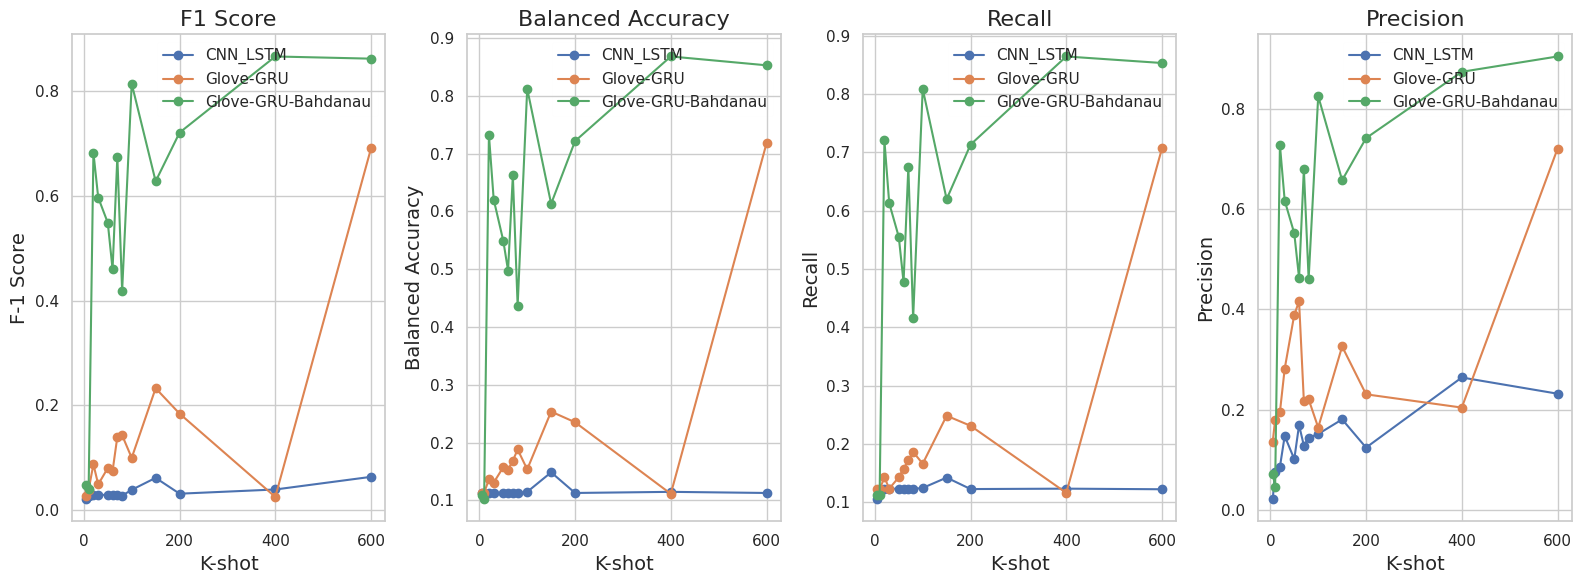

In [ ]:
plot_max_metrics(model_metrics, k_values)

---
##Few-Shot Learning Performance Analysis

1. **F1 Score**

Glove-GRU-Bahdanau consistently achieves the highest F1 scores across all K values.
Glove-GRU starts with very low F1 but improves significantly at higher K (e.g., 600).
CNN_LSTM remains relatively flat and low throughout. We can interpret Glove-GRU-Bahdanau provides the best balance between precision and recall, even with fewer samples.

2. **Balanced Accuracy**

Glove-GRU-Bahdanau remains high and stable.
Glove-GRU sees a sudden spike at K=600.
CNN_LSTM performs poorly and shows almost no change. We can interpret Bahdanau-based models are more reliable for balanced class performance.

3. **Recall**

Glove-GRU-Bahdanau maintains high recall across all values.
Glove-GRU increases significantly at K=600.
CNN_LSTM remains consistently low. We can interpret Bahdanau is effective at identifying true positives, which is critical in many classification tasks.

4. **Precision**
Glove-GRU-Bahdanau demonstrates high precision even with fewer shots.
Glove-GRU and CNN_LSTM start low but Glove-GRU shows some improvement.
We can interpret Bahdanau makes fewer false-positive predictions, ensuring more trustworthy outputs.

###Overall Conclusion
Glove-GRU-Bahdanau is the most performant and stable model, especially in low-data scenarios (few-shot learning).
Glove-GRU benefits significantly from more data but lags behind until high K.
CNN_LSTM underperforms across all metrics and K values.